In [230]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Variational quantum linear solver

The problem $A.x = b$ that we aim to solve is that of preparing an ansatz quantum state $\ket{x(\theta)}$, such that $A\ket{x(\theta)}$  is proportional to $\ket{b}$, say $$\ket{\psi(\theta)}=\frac{A\ket{x(\theta)}}{\sqrt{\bra{x(\theta)}A^\dagger A \ket{x(\theta)}}} \xrightarrow[]{\text{Optimizing } \theta} \ket{b} = U\ket{0}.$$
In the other words, we minize the cost function $$C = 1- \left|\braket{b|\psi(\theta)}\right|^2 =1 - \frac{\sum_{l,l'}c_l c_{l'}^* \bra{x(\theta)}A^\dagger_{l'} U \ket{0}\bra{0}U^\dagger A_l \ket{x(\theta)}}{\sum_{l,l'}c_l c_{l'}^*\bra{x(\theta)}A^\dagger_{l'} A_l \ket{x(\theta)}}$$


This cost function however might be experimentally challenging since it requires us to apply all the unitaries ($U,A_l$ and $\ket{x(\theta)}$) in a controlled way, i.e., conditioned on the state of an ancillary qubit. The workaround one easier to measure and, at the same time, leads to the same optimal solution, can be obtained by replacing the projector $\ket{0}\bra{0}$ by the following positive operator $$R = \frac{1}{2}+\frac{1}{2n}\sum_{j=0}^{n-1}Z_j.$$ This gives a new cost function that behave in the same way of optimization result $$C = \frac{1}{2}-\frac{1}{2n}\frac{\sum_{j=0}^{n-1}\sum_{l,l'}c_l c_{l'}^* \lambda_{l,l',j}}{\sum_{l,l'}c_l c_{l'}^*\lambda_{l,l',-1}},$$ which can be computed whenever we are able to measure the following coefficients $$\lambda_{l,l',j} = \bra{x(\theta)}A^\dagger_{l'} U Z_j U^\dagger A_l \ket{x(\theta)},$$ where we used the convention that $Z_{-1} = \mathbb{I}$. Compared with the previous cost function, the main advantage of this approach is that only the unitary operations $A_l, A^\dagger_{l}$ and $Z_j$ controlled by an external ancillary qubit, while $V,V^\dagger, U$ and $U^\dagger$ can be directly applied to the system. This is particularly convenient whenever $V,U$ have a complex structure

# Setting of the main hyper-parameters of the model

In [435]:
n_qubits = 2  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
ancilla_idx = n_qubits  # Index of the one ancillary qubit (last position).
tot_qubits = n_qubits + 1  # Total number of qubits (system + ancillary).
steps = 50  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 1  # Seed for random number generator
dim = 2 ** n_qubits  # Dimension of the problem space

# Circuits of the quantum linear problem

## Simple Example

Operator associated to A matrix and vector B. In this example, where the A operator is defined $$ A = c_0A_0 + c_1A_1 + c_2A_2 = \mathbb{I} + 0.2 X_0Z_1 + 0.2 X_0,$$
and the vector $\ket{b}$ is defined as follow $$\ket{b}=U\ket{b}=H_0 H_1 H_2 \ket{b}$$

In [ ]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 0.2, 0.2])

def CA(idx):
    """Controlled versions of the unitary components A_idx of the problem matrix A."""
    # A = I + 0.2 X_0Z_1 + 0.2 X_0
    if idx == 0: 
        # Identity operation
        None

    elif idx == 1: # X_0 Z_1
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2: # X_0
        qml.CNOT(wires=[ancilla_idx, 0])

In [ ]:
def U_b(vector):
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    # Normalize the input vector
    # norm_vector = vector / np.linalg.norm(vector)
    # Initialize the quantum state to the normalized vector on the target wires
    # qml.StatePrep(norm_vector, wires=[i for i in range(n_qubits)]) # There might be a problem with this stateprepare function
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

## For a general Hermitian matrix A

Here we get input a Hermitian matrix A, and then use the qml.pauli_decompose() function to decompose A into a sum of Pauli product operators. For instance, we have Hermitian A $$A = \begin{bmatrix}
1 & 0 & 0 & 1 \\
0 & 2 & 1 & 0 \\
0 & 1 & 3 & 0 \\
1 & 0 & 0 & 4 \\
\end{bmatrix}$$ is decomposed into 
$$A = 2.5 \, I_0 \otimes I_1 
- 0.5 \, I_0 \otimes Z_1 
+ 1.0 \, X_0 \otimes X_1 
- 1.0 \, Z_0 \otimes I_1$$. 
And the vector $\ket{b}$ is $\left[\frac{1}{\sqrt{4}},\frac{1}{\sqrt{4}},\frac{1}{\sqrt{4}},\frac{1}{\sqrt{4}}\right] = H_0 H_1 \ket{0}$

In [443]:
# Example: 2-qubit Hermitian matrix
A = np.array([
    [1, 0, 0, 1],
    [0, 2, 1, 0],
    [0, 1, 3, 0],
    [1, 0, 0, 4]
], dtype=complex)

Init_vector = np.array([0.5,0.5,0.5,0.5])  # Vector Initial state |b>

# Ensure it's Hermitian
assert np.allclose(A, A.conj().T)
# Decompose the Hermitian matrix into Pauli operators
hamiltonian = qml.pauli_decompose(A)
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = hamiltonian.coeffs
# Display the result
print(hamiltonian)

2.5 * (I(0) @ I(1)) + -0.5 * (I(0) @ Z(1)) + 1.0 * (X(0) @ X(1)) + -1.0 * (Z(0) @ I(1))


In [444]:
def CA_gate(idx, ancilla_idx, hamiltonian):
    """Controlled versions of the unitary components A_idx of the problem matrix A."""
    
    for i in range(n_qubits):
        if hamiltonian.ops[idx][i].name == 'Identity':
            continue    # Idientity operation, do nothing
        elif hamiltonian.ops[idx][i].name == 'PauliX':
            qml.CNOT(wires=[ancilla_idx, i]) # Apply X gate 
        elif hamiltonian.ops[idx][i].name == 'PauliZ':
            qml.CZ(wires=[ancilla_idx, i]) # Apply Z gate
        elif hamiltonian.ops[idx][i].name == 'PauliY':
            qml.CY(wires=[ancilla_idx, i]) # Apply Y gate

# Variational quantum circuit

The very simple parametrized circuit generates the solution state $\ket{x}$

In [445]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

# Hadamard test

## VQLS

The circuit is based on the Hadamard test to be used to estimate the coefficients $\lambda_{l,l',j}$ defined in the above

In [322]:
dev_mu = qml.device("lightning.qubit", wires= tot_qubits)

@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "lambda", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    # CA(l) # Manual defined operators for specific A
    CA_gate(l, ancilla_idx, hamiltonian) # Generalized operators for a Hermitian A

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    U_b(Init_vector)# In this specific example Adjoint(U_b) = U_b.

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b(Init_vector)

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    # CA(lp) # Manual defined operators for specific A
    CA_gate(lp, ancilla_idx, hamiltonian) # Generalized operators for a Hermitian A
    
    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

To get the real and imaginary parts of $\lambda_{l,l',j}$, run the previous quantum circuit with and without a phase-shift of the ancillary qubit, which is done by the below function

In [323]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

## VQE

In [324]:
def A_gate(idx, hamiltonian):
    """Controlled versions of the unitary components A_idx of the problem matrix A."""
    
    for i in range(n_qubits):
        if hamiltonian.ops[idx][i].name == 'Identity':
            continue    # Idientity operation, do nothing
        elif hamiltonian.ops[idx][i].name == 'PauliX':
            qml.X(wires=[i]) # Apply X gate 
        elif hamiltonian.ops[idx][i].name == 'PauliZ':
            qml.Z(wires=[i]) # Apply Z gate
        elif hamiltonian.ops[idx][i].name == 'PauliY':
            qml.Y(wires=[i]) # Apply Y gate

Calculate $\left|\bra{x(\theta)}A_l^\dagger U_b \ket{0}\right|^2$

In [325]:
dev_mu = qml.device("lightning.qubit", wires= tot_qubits)

@qml.qnode(dev_mu, interface="autograd")
def VQE_expectation(weights, l=None, lp=None):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    # CA(l) # Manual defined operators for specific A
    A_gate(l, hamiltonian) # Generalized operators for a Hermitian A

    if lp == None:  
        # Adjoint of the unitary U_b associated to the problem vector |b>.
        U_b() # In this specific example Adjoint(U_b) = U_b.
    else:
        A_gate(lp, hamiltonian) 
        qml.adjoint(variational_block)(weights)
        
    return  qml.probs(wires=range(n_qubits))


# Cost Function

Estimating $\bra{x(\theta)}A_l^\dagger A_{l'} \ket{x(\theta)} = \lambda_{l,l',-1}$

In [326]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)
    return abs(norm)

In [327]:
# For VQE 
def VQE_psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            psi_norm = np.sqrt(VQE_expectation(weights, l, lp)[0]) # !!!??? this does not work for Pennylane optimizer. The <psi| A A+ |psi> can be negative
            norm = norm + c[l] * c[lp] * psi_norm 
    return abs(norm)

Given the analytical expression of cost function in terms of the coefficients $\lambda_{l,l',j}$ defined above, we can define the cost function of our minimization problem

In [328]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

In [329]:
# For VQE. This does not work in sense of |c_1 + c_2| != |c_1|*|c_2|
def cost_loc_VQE(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        mu_sum = mu_sum + np.random.choice([1, -1]) * abs(c[l])**2 * VQE_expectation(weights, l, lp=None)[0]

    # Cost function C_L
    return abs(1 - mu_sum / psi_norm(weights))

# Exprimentally Variational Optimization

In [464]:
# Set the random seed
np.random.seed(rng_seed)
# Initialize the quantum weights
w = q_delta * np.random.randn(n_qubits, requires_grad=True)
# Define the optimizer
opt = qml.GradientDescentOptimizer(eta)

In [465]:
# Variational optimization loop
cost_history = []
for it in range(steps):
        w, cost = opt.step_and_cost(cost_loc, w)
        print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
        cost_history.append(cost)

Step   0       Cost_L = 0.0463470
Step   1       Cost_L = 0.0448951
Step   2       Cost_L = 0.0435315
Step   3       Cost_L = 0.0422416
Step   4       Cost_L = 0.0410140
Step   5       Cost_L = 0.0398394
Step   6       Cost_L = 0.0387104
Step   7       Cost_L = 0.0376210
Step   8       Cost_L = 0.0365664
Step   9       Cost_L = 0.0355423
Step  10       Cost_L = 0.0345454
Step  11       Cost_L = 0.0335726
Step  12       Cost_L = 0.0326214
Step  13       Cost_L = 0.0316895
Step  14       Cost_L = 0.0307748
Step  15       Cost_L = 0.0298752
Step  16       Cost_L = 0.0289891
Step  17       Cost_L = 0.0281146
Step  18       Cost_L = 0.0272499
Step  19       Cost_L = 0.0263935
Step  20       Cost_L = 0.0255435
Step  21       Cost_L = 0.0246985
Step  22       Cost_L = 0.0238567
Step  23       Cost_L = 0.0230166
Step  24       Cost_L = 0.0221767
Step  25       Cost_L = 0.0213359
Step  26       Cost_L = 0.0204928
Step  27       Cost_L = 0.0196468
Step  28       Cost_L = 0.0187972
Step  29      

The manual defined optimization function using gradient descend

In [385]:
# # Finite difference gradient approximation
# def finite_difference_grad(cost_fn, x, eps=1e-6):
#     grad = np.zeros_like(x)
#     for i in range(len(x)):
#         x_forward = np.copy(x)
#         x_backward = np.copy(x)
#         x_forward[i] += eps
#         x_backward[i] -= eps
#         grad[i] = (cost_fn(x_forward) - cost_fn(x_backward)) / (2 * eps)
#     return grad

# # Gradient descent algorithm
# def gradient_descent(cost_fn, x0, learning_rate=0.1, steps=100):
#     x = np.copy(x0)
#     history = []
#     for step in range(steps):
#         grad = finite_difference_grad(cost_fn, x)
#         x -= learning_rate * grad
#         cost = cost_fn(x)
#         history.append(cost)
#         print(f"Step {step:03d}: x = {x}, cost = {cost}")
#     return x, history
# w, history = gradient_descent(cost_loc_VQE, w, learning_rate= 0.8, steps=20)

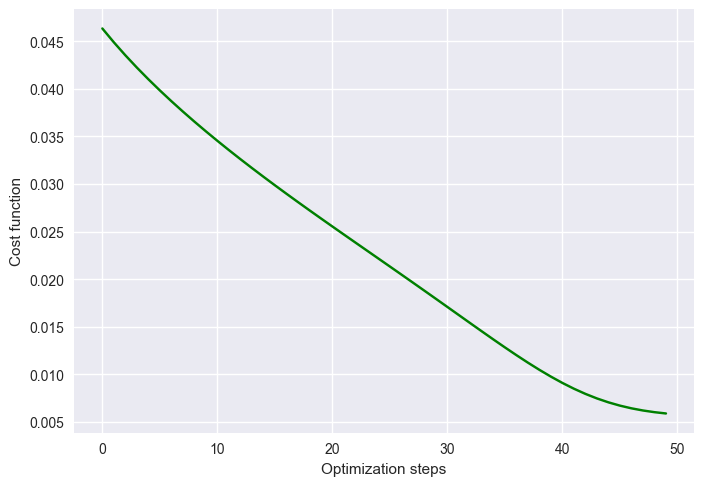

In [466]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

# Comparison of quantum and classical results

## Classical algorithm

Generate the defined matrix A from example above

In [467]:
# Classical algorithm
# The explicit matrix representation of Pauli matrix.
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
A_0 = np.identity(dim)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A_num = A # c[0] * A_0 + c[1] * A_1 + c[2] * A_2
b = Init_vector # np.ones(dim) / np.sqrt(dim)

In [468]:
print("A = \n", A_num)
print("b = \n", b)

A = 
 [[1.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 2.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 3.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 4.+0.j]]
b = 
 [0.5 0.5 0.5 0.5]


Classical algorithm via np.linalg

In [469]:
# The solution can be computed via a matrix inversion:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

In [470]:
# In order to compare x with the quantum state |x>, we normalize and square its elements.
c_probs = (x / np.linalg.norm(x)) ** 2

## Preparation of the quantum solution

Given the variational weights w that we have previously optimized, we can generate the quantum state $\ket{x}$. By measuring $\ket{x}$ in the computational basis we can estimate the probability of each basis state.

In [471]:
# Prepare a new quantum device for sampling define the associated qnode circuit
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [472]:
# Generate the quantum state |x> and sample it
# Using the variational weights w that we have previously optimized.
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots

## Comparison

In [473]:
# Classical result
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.83333333+0.j 0.13333333+0.j 0.03333333+0.j 0.        +0.j]


In [474]:
# Quantum result
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.727206 0.219306 0.041121 0.012367]


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\transforms.py:788: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


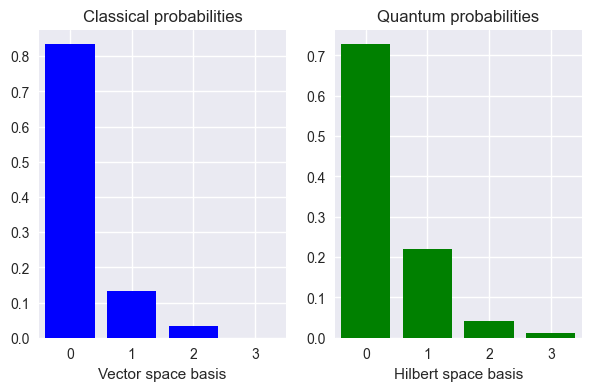

In [475]:
# Graphically visualize both distributions.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

# References

1. Carlos Bravo-Prieto, Ryan LaRose, Marco Cerezo, Yigit Subasi, Lukasz Cincio, Patrick J. Coles. “Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems.” arXiv:1909.05820, 2019.

2. Pennylane VSQL Tutorial: https://pennylane.ai/qml/demos/tutorial_vqls#setting-of-the-main-hyper-parameters-of-the-model

3. Y. Zhou et al., "Quantum computing in power systems," in iEnergy, vol. 1, no. 2, pp. 170-187, June 2022, doi: 10.23919/IEN.2022.0021.